In [33]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [2]:
emb_df = pd.read_csv('../data/embedding/Glove_embedding_output.csv',index_col=0)

In [72]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [35]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [42]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 10)

In [98]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 1

label2 = pd.read_csv('../data/raw/labels/duckboat/population.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 2

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/population.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 3

In [102]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,denverpost.com/2018/07/20/greeley-police-lip-s...,1
1,bbc.com/news/av/world-asia-44875089/thai-cave-...,1
2,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,1
3,chron.com/news/crime/article/young-nubians-rev...,1
4,cnbc.com/2018/07/20/at-least-13-die-when-duck-...,1
...,...,...
1920,beforeitsnews.com/opinion-conservative/2018/07...,3
1921,washingtonpost.com/news/powerpost/paloma/the-h...,3
1922,feeds.nydailynews.com/~r/nydnrss/news/national...,3
1923,news.google.com/stories/caaqoqgkijndqkltsurvsm...,3


In [111]:
clean_df.merge(label_df, on='canonicalUrl', how='left').dropna()

,index,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
238,165242,44,dailymail.co.uk/wires/ap/article-5969291/hawai...,7/19/2018 6:28:47 AM -04:00,Hawaii searches for safe spots for people to s...,"Thursday, Jul 19th 2018 5-Day Forecast ### Adv...",1,en,73,10661,2.0
914,84099,117,newsday.com/long-island/politics/spin-cycle/cu...,7/19/2018 5:31:58 AM -04:00,Cuomo giving up donations linked to corruption...,Get breaking news alerts from Newsday ### Turn...,1,en,63,2054,3.0
1631,91940,6,yahoo.com/news/m/3c9bfadd-8455-3f28-a7a1-d4fa2...,7/19/2018 5:35:38 AM -04:00,Russian 'agent offered sex for job in US',Russian 'agent offered sex for job in US' ### ...,1,en,41,821,3.0
1812,200722,308,beforeitsnews.com/opinion-liberal/2018/07/weap...,7/19/2018 5:13:16 AM -04:00,Weaponizing the First Amendment,Weaponizing the First Amendment! ### Wednesday...,1,en,31,3261,3.0
1964,142993,76,chron.com/news/media/how-doordash-plans-to-use...,7/19/2018 6:09:53 AM -04:00,How DoorDash Plans to Use Its New Round of Fun...,How DoorDash Plans to Use Its New Round of Fun...,1,en,70,832,3.0
2062,20108,118,philly.com/philly/entertainment/movies/dark-mo...,7/19/2018 6:29:50 AM -04:00,'Dark Money' examines the dark side of campaig...,'Dark Money' examines the dark side of campaig...,1,en,65,3882,2.0
2266,164691,44,dailymail.co.uk/tvshowbiz/article-5970199/chri...,7/19/2018 8:27:14 AM -04:00,films hilarious clip of Luna tucking into past...,comments ### She is well-known for her love of...,1,en,67,3483,2.0
2469,21084,34,bbc.co.uk/news/health-41483322,7/19/2018 5:27:31 AM -04:00,"Check NHS cancer, A&E and operations targets i...","Check NHS cancer, A&E and operations targets i...",1,en,68,4959,2.0
2750,142869,76,chron.com/neighborhood/cyfair/sports/article/y...,7/19/2018 7:59:38 PM -04:00,Youth players maximize potential through north...,Youth players maximize potential through north...,1,en,65,8466,2.0
3027,92011,6,yahoo.com/news/u-judge-orders-accused-russian-...,7/19/2018 12:28:34 PM -04:00,U.S. judge orders accused Russian agent Butina...,U.S. judge orders accused Russian agent Butina...,1,en,53,540,3.0


In [43]:
# shuffle df to distribute publication randomly and sample
clean_df = clean_df.sample(frac=0.05)
clean_df.shape

(8833, 10)

In [71]:
clean_df.head()

,index,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len
117952,119072,1494,jamestownsun.com/opinion/columns/4474446-comme...,7/20/2018 6:32:31 AM -04:00,Heidi Heitkamp’s political allies hire actors ...,Commentary: Heidi Heitkamp’s political allies ...,1,en,123,884
159412,161012,1203,azdailysun.com/lifestyles/health-med-fit/calif...,7/19/2018 10:23:27 PM -04:00,California’s ACA Rates To Rise 8.7% Next Year,"Subscribe to discover fast, unlimited access. ...",1,en,45,7260
162196,163812,494,delawareonline.com/story/tech/nation-now/2018/...,7/19/2018 5:47:05 AM -04:00,NASA wants more humans to walk on the moon — a...,Viewers can get as close as 5 miles from the l...,1,en,59,28411
113552,114642,1997,wifr.com/content/news/dolphins-anthem-punishme...,7/19/2018 11:33:00 PM -04:00,Dolphins anthem punishment includes suspensions,Article ### Dolphins anthem punishment include...,1,en,47,1508
1913,1920,886,wect.com/story/38683590/steel-company-to-creat...,7/19/2018 5:42:34 PM -04:00,Steel company to create 180 jobs,Steel company to create 180 jobs in South Caro...,1,en,32,1049


In [44]:
sample_emb_df = emb_df.loc[clean_df.index]

In [45]:
tree = BallTree(sample_emb_df)
neighbors = tree.query_radius(sample_emb_df, 0.2)
neighbors_count = [len(n) for n in neighbors]

In [46]:
np.mean(neighbors_count)

1.818295030001132

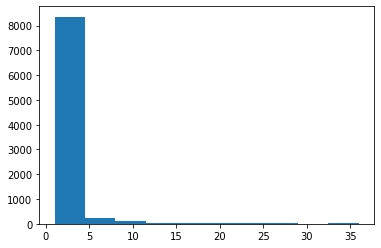

In [47]:
plt.hist(neighbors_count);

In [48]:
pop_node = article_df.iloc[np.argmax(neighbors_count)]
pop_node.text

"Print ### Share: ### The 29-year-old Russian woman accused of covertly working as a foreign agent while living in the United States allegedly offered to have sex with an unnamed individual in return for a job in the United States, prosecutors said Wednesday. ### And that’s not all. According to new court filings,\xa0Maria Butina allegedly “gained access” to “an extensive network of U.S. persons in positions to influence political\xa0activities in the United States” by living with and having a personal relationship with another individual. ### Prosecutors revealed the new allegations against Butina in documents filed Wednesday, as Butina\xa0pleaded not guilty and a judge ordered her held without bond in court. ### Prosecutors had asked the judge in the case to keep Butina in jail before her trial, arguing she’s a flight risk. ### “Butina is a Russian citizen with no meaningful ties to the United States; she has every reason to flee this prosecution,” U.S. Attorney Jessie K. Liu wrote i

In [49]:
def create_graph(neighbors):
    G = nx.Graph()
    G.add_nodes_from(list(range(len(neighbors))))

    for node in range(len(neighbors)):
        neighbor = neighbors[node]
        for n in neighbor:
            G.add_edge(node, n)
    return G

In [50]:
G = create_graph(neighbors)

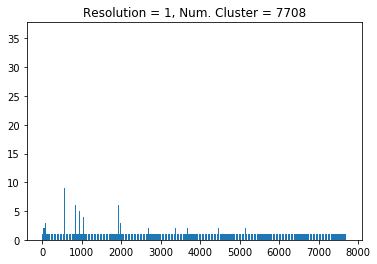

In [51]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [52]:
np.argmax(cluster_sizes)

247

In [53]:
np.max(cluster_sizes)

36

In [54]:
np.median(cluster_sizes)

1.0

In [55]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [56]:
pc = prune_cluster(cluster, 10)

In [57]:
article_cluster =list(map(lambda d: clean_df.iloc[d[1]], pc.items()))
len(article_cluster)

12

In [58]:
len(article_cluster[0].title.tolist())

17

In [61]:
pc.keys()

dict_keys([87, 247, 390, 451, 491, 568, 584, 799, 849, 927, 1833, 2405])

In [112]:
n = len(pc.keys())
sample_cluster = np.random.ran
article_cluster[0].title.tolist()

["Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Years | Patch",
 "Iconic 'Brady Bunch' House Hits Market For First Time In 50 Ye

In [63]:
list(map(lambda x: x[:100], article_cluster[0].text.tolist()))

["real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ### Iconic 'Brady Bunch' House Hits Market For Fir",
 "real estate Shared from the Studio City, CA Patch ###

In [76]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 1

In [78]:
label1

,canonicalUrl,label
0,denverpost.com/2018/07/20/greeley-police-lip-s...,1
1,bbc.com/news/av/world-asia-44875089/thai-cave-...,1
2,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,1
3,chron.com/news/crime/article/young-nubians-rev...,1
4,cnbc.com/2018/07/20/at-least-13-die-when-duck-...,1
...,...,...
706,bbc.com/news/uk-scotland-44860771,1
707,yahoo.com/news/m/b6cf627b-7fb2-32c9-bfd1-8e852...,1
708,news.google.com/publications/caaqbwgkmpkygqswj...,1
709,politico.com/newsletters/morning-tech/2018/07/...,1


In [66]:
assign = []
for key, value in pc.items():
    for idx in value:
        assign.append((key, idx))

assign_df = pd.DataFrame(assign)
assign_df.columns = ['cluster', 'index']

In [67]:
assign_df = assign_df.set_index('index')

In [68]:
assign_df

,cluster
index,
87,87
988,87
1613,87
2059,87
2812,87
...,...
4937,2405
5803,2405
7093,2405


In [91]:
with_assign = clean_df.join(assign_df).dropna()

In [96]:
with_assign.merge(label1, on='canonicalUrl').dropna()

,index,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,cluster,label


In [97]:
label1.shape

(711, 2)